In [1]:
import pandas as pd
import numpy as np
from sklearn import set_config
import matplotlib.pyplot as plt
from sklearn.compose import make_column_selector
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.preprocessing import OneHotEncoder

set_config(display='diagram')

# Download data from the url below:
# https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if
source = pd.read_csv('~/Downloads/Traffic_Crashes_-_Crashes.csv')
print('source shape:', source.shape)
# print('source columns:', list(source.columns))

source shape: (652641, 49)


<h1>Background</h1>
<p>The trafic crash dataset is from <em><strong>Chicago Data Portal</strong>, link: https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if</em>. I noticed one field called 'HIT_AND_RUN_I' (ending 'I' for involved), thus I am curious what factors are most related to hit and run? And can we predict the driver behavior after the crash? For what percentage of accuracy? Could a case study be explained as an example?</p>
<p>Below is the content, and how I use data to answer the above questions.</p>

<h1>Content</h1>
<ul>
    <li>EDA</li>
        <ul>
            <li>Column Selection</li>
            <li>Distribution Analysis</li>
                <ul>
                    <li>Separate continuous and discrete columns</li>
                    <li>Check continuous variable columns</li>
                    <li>Check discrete variable columns</li>
                </ul>
            <li>Outlier Detection</li>
            <li>Data Imputation</li>
            <li>Check Dependent Variable Skewness (Balancing)</li>
            <li>Numeric Data Correlation Analysis</li>
            <li>Encoding Analysis</li>
            <li>Dependent Variable Explained Variance Analysis</li>
        </ul>
    <li>Feature Engineering</li>
        <ul>
            <li>PCA</li>
            <li>Standardization</li>
            <li>Data Balancing & Basedline Metrics</li>
            <li>Train Test Split</li>
        </ul>
    <li>Modeling</li>
        <ul>
            <li>Logistic Regression</li>
            <li>Decision Tree</li>
            <li>Random Forest</li>
            <li>XGBoost</li>
            <li>Stacking</li>
        </ul>
    <li>Evaluation & Explainability</li>
        <ul>
            <li>Model Evaluation</li>
            <ul>
                <li>Model Comparision (AUC-ROC)</li>
                <li>Model Performance Overview</li>
            </ul>
            <li>Model Explainability</li>
            <ul>
                <li>Shapley Summary</li>
                <li>Individual Case Study Explaination</li>
            </ul>
        </ul>
</ul>

# EDA

## Column Selection

In [2]:
def filter_column_list(columns):
    """
    Manually remove unuseful columns like ID, geolocation, posteriors etc.
    
    Args:
        columns: Original dataframe columns.
    
    Returns:
        List of filtered column names
    """
    
    columns = list(columns)
    
    # initial identiders such as ID and names
    identifiers = ['CRASH_RECORD_ID', 'RD_NO', 'STREET_NO', 'STREET_NAME', 'BEAT_OF_OCCURRENCE']
    
    # geolocation like latitude and longitude
    location_info = ['LATITUDE', 'LONGITUDE', 'LOCATION']
    
    # posteriors estimation or behaviour after a car crash happened
    posteriors = ['POSTED_SPEED_LIMIT', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 
                  'PHOTOS_TAKEN_I', 'TRAFFIC_CONTROL_DEVICE']
    
    # date, note: crash hour, day of week, month have extra columns to be reserved in the original dataset.
    dates = ['CRASH_DATE_EST_I', 'CRASH_DATE', 'DATE_POLICE_NOTIFIED']
    
    # combine unuseful columns
    discard_columns = identifiers + location_info + posteriors + dates
    
    # filter original columns
    valid_columns = [column_name for column_name in columns if column_name not in discard_columns]
    
    print('original column length:', len(columns))
    print('filtered column length:', len(valid_columns))
    
    return valid_columns

valid_columns = filter_column_list(source.columns)
print('filtered valid columns are:', valid_columns)

original column length: 49
filtered column length: 32
filtered valid columns are: ['DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'STREET_DIRECTION', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS', 'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH']


## Distribution Analysis

### Separate continuous and discrete columns

In [3]:
# filter data source
filtered_source = source[valid_columns]
filtered_source.info()

# select object data type columns
category_selector = make_column_selector(dtype_include=object)
category_columns = category_selector(filtered_source)
print('length of discrete columns:', len(category_columns))

# select numeric data type columns
numeric_selector = make_column_selector(dtype_include=np.number)
numeric_columns = numeric_selector(filtered_source)
print('length of continuous columns:', len(numeric_columns))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652641 entries, 0 to 652640
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   DEVICE_CONDITION               652641 non-null  object 
 1   WEATHER_CONDITION              652641 non-null  object 
 2   LIGHTING_CONDITION             652641 non-null  object 
 3   FIRST_CRASH_TYPE               652641 non-null  object 
 4   TRAFFICWAY_TYPE                652641 non-null  object 
 5   LANE_CNT                       198990 non-null  float64
 6   ALIGNMENT                      652641 non-null  object 
 7   ROADWAY_SURFACE_COND           652641 non-null  object 
 8   ROAD_DEFECT                    652641 non-null  object 
 9   REPORT_TYPE                    635247 non-null  object 
 10  CRASH_TYPE                     652641 non-null  object 
 11  INTERSECTION_RELATED_I         149289 non-null  object 
 12  NOT_RIGHT_OF_WAY_I            

### Check continuous variable columns

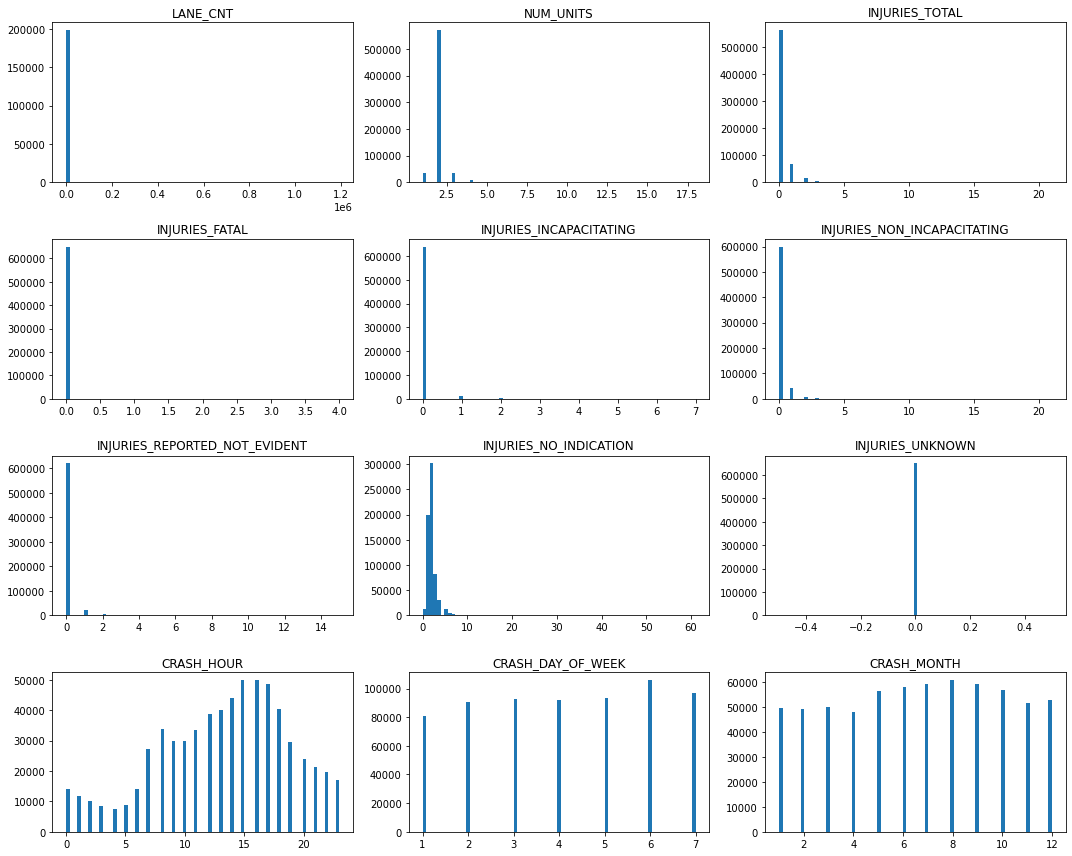

In [4]:
fig = plt.figure(figsize=(15, 12))
for index, name in enumerate(numeric_columns):
    plt.subplot(4, 3, index+1)
    plt.hist(filtered_source[name], bins=75)
    plt.title(name)
    plt.tight_layout()
plt.show() 

In [5]:
filtered_source[numeric_columns].describe()

,LANE_CNT,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH
count,1.989900e+05,652640.000000,651261.000000,651261.000000,651261.000000,651261.000000,651261.000000,651261.000000,651261.0,652641.000000,652641.000000,652641.000000
mean,1.333114e+01,2.034491,0.184835,0.001159,0.019949,0.103992,0.059735,2.009165,0.0,13.223448,4.124807,6.632706
std,2.961743e+03,0.451605,0.558178,0.036970,0.164992,0.415510,0.314307,1.159544,0.0,5.549219,1.980988,3.369320
min,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000
25%,2.000000e+00,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,9.000000,2.000000,4.000000
50%,2.000000e+00,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,14.000000,4.000000,7.000000
75%,4.000000e+00,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,17.000000,6.000000,9.000000
max,1.191625e+06,18.000000,21.000000,4.000000,7.000000,21.000000,15.000000,61.000000,0.0,23.000000,7.000000,12.000000


#### Continuous variables overview

<table style="width: 100%;">
  <tr>
    <th>Column Name</th>
    <th>Clarification</th>
    <th>Observation</th>
    <th>Implication & Hypothesis</th>
  </tr>
  <tr>
    <td>LANE_CNT</td>
    <td>Total number of through lanes in either direction, excluding turn lanes, as determined by reporting officer (0 = intersection)</td>
    <td style='color: red'>SCALE IS TOO HIGH</td>
    <td>Potential outliers exist</td>
  </tr>
  <tr>
    <td>NUM_UNITS</td>
    <td>Number of units involved in the crash. A unit can be a motor vehicle, a pedestrian, a bicyclist, or another non-passenger roadway user. Each unit represents a mode of traffic with an independent trajectory.</td>
    <td>Poisson distribution</td>
    <td>Seem OK</td>
  </tr>
  <tr>
    <td>INJURIES_TOTAL</td>
    <td>Total persons sustaining fatal, incapacitating, non-incapacitating, and possible injuries as determined by the reporting officer</td>
    <td>Poisson distribution</td>
    <td>Seem OK</td>
  </tr>
  <tr>
    <td>INJURIES_FATAL</td>
    <td>Total persons sustaining fatal injuries in the crash</td>
    <td>Exponential distribution</td>
    <td>Seem OK</td>
  </tr>
  <tr>
    <td>INJURIES_INCAPACITATING</td>
    <td>Total persons sustaining incapacitating/serious injuries in the crash as determined by the reporting officer. Any injury other than fatal injury, which prevents the injured person from walking, driving, or normally continuing the activities they were capable of performing before the injury occurred. Includes severe lacerations, broken limbs, skull or chest injuries, and abdominal injuries.</td>
    <td>Exponential distribution</td>
    <td>Seem OK</td>
  </tr>
  <tr>
    <td>INJURIES_NON_INCAPACITATING</td>
    <td>Total persons sustaining non-incapacitating injuries in the crash as determined by the reporting officer. Any injury, other than fatal or incapacitating injury, which is evident to observers at the scene of the crash. Includes lump on head, abrasions, bruises, and minor lacerations.</td>
    <td>Exponential distribution</td>
    <td>Seem OK</td>
  </tr>
  <tr>
    <td>INJURIES_REPORTED_NOT_EVIDENT</td>
    <td>Total persons sustaining possible injuries in the crash as determined by the reporting officer. Includes momentary unconsciousness, claims of injuries not evident, limping, complaint of pain, nausea, and hysteria.</td>
    <td>Exponential distribution</td>
    <td>Seem OK</td>
  </tr>
  <tr>
    <td>INJURIES_NO_INDICATION</td>
    <td>Total persons sustaining no injuries in the crash as determined by the reporting officer</td>
    <td>Exponential distribution</td>
    <td>Seem OK</td>
  </tr>
  <tr>
    <td>INJURIES_NO_INDICATION</td>
    <td>Total persons sustaining no injuries in the crash as determined by the reporting officer</td>
    <td>Poisson distribution</td>
    <td>Seem OK</td>
  </tr>
  <tr>
    <td>INJURIES_UNKNOWN</td>
    <td>Total persons for whom injuries sustained, if any, are unknown</td>
    <td style='color: red'>ONLY ZERO VALUE AND NULL</td>
    <td>Suggest to discard</td>
  </tr>
  <tr>
    <td>CRASH_HOUR</td>
    <td>The hour of the day component of CRASH_DATE.</td>
    <td>Poisson distribution</td>
    <td>Seem OK</td>
  </tr>
  <tr>
    <td>CRASH_DAY_OF_WEEK</td>
    <td>The day of the week component of CRASH_DATE. Sunday=1</td>
    <td>Uniform or Gaussian distribution</td>
    <td>Seem OK</td>
  </tr>
  <tr>
    <td>CRASH_MONTH</td>
    <td>The month component of CRASH_DATE.</td>
    <td>Uniform or Gaussian distribution</td>
    <td>Seem OK</td>
  </tr>
</table>

### Check discrete variable columns

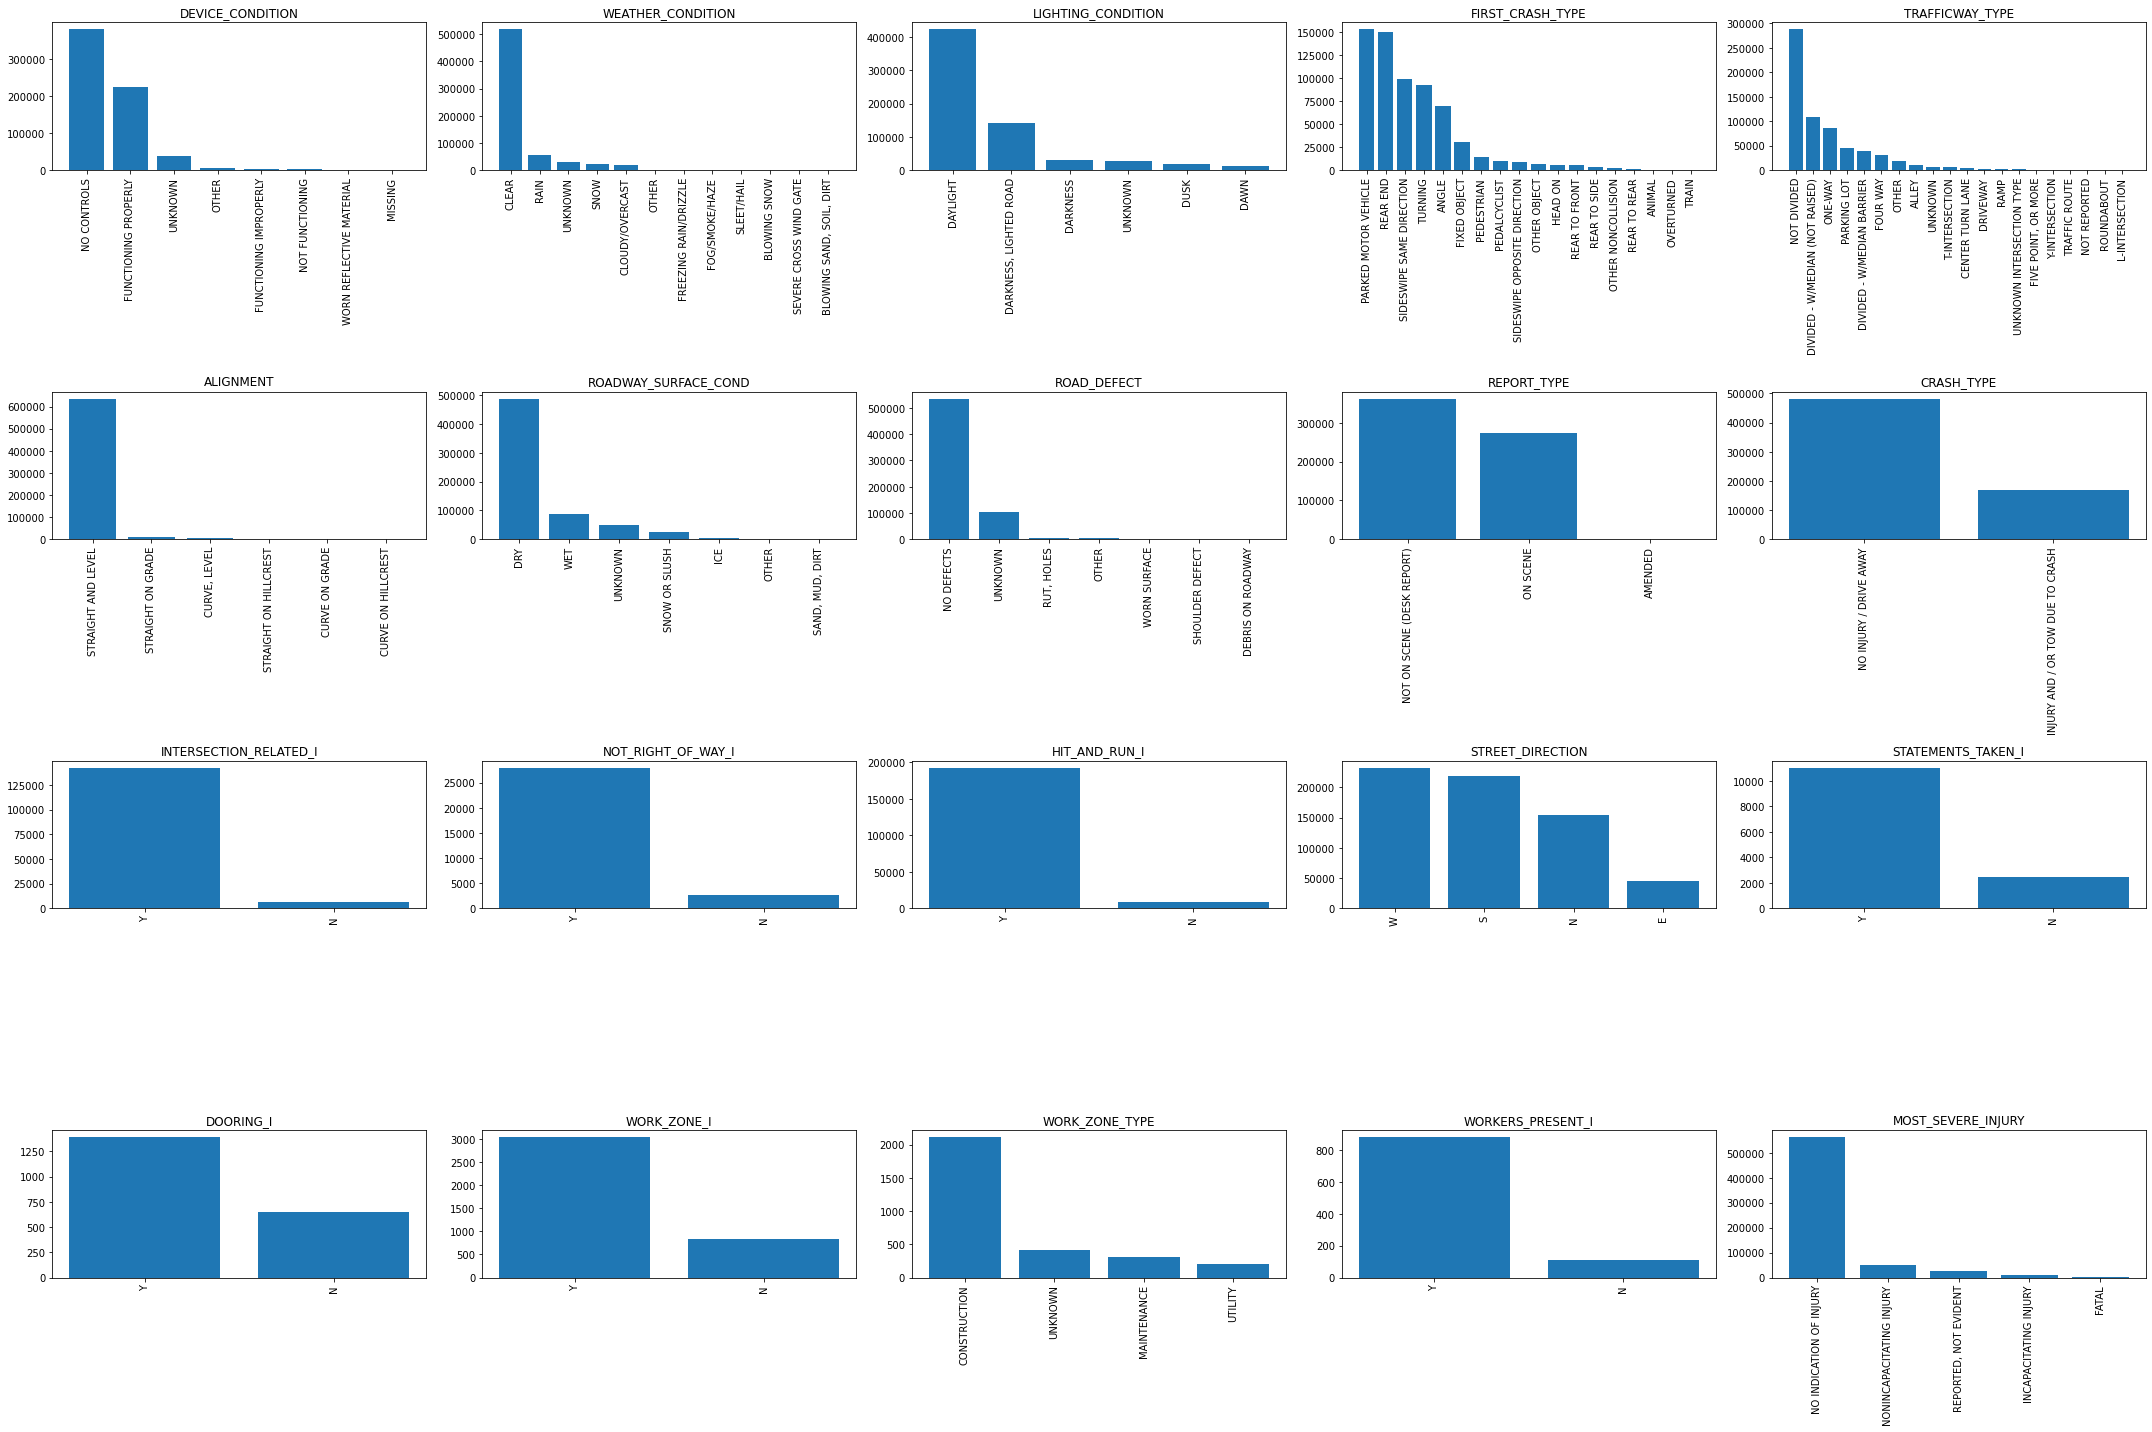

In [6]:
fig = plt.figure(figsize=(30, 20))
for index, name in enumerate(category_columns):
    plt.subplot(4, 5, index + 1)
    
    index_name = filtered_source[name].value_counts().index
    index_value = filtered_source[name].value_counts().values
    
    plt.bar(index_name, index_value)
    plt.xticks(rotation=90)
    plt.title(name)
    plt.tight_layout()
plt.show()

<p>All categorical data seems good</p>

## Outlier Detection

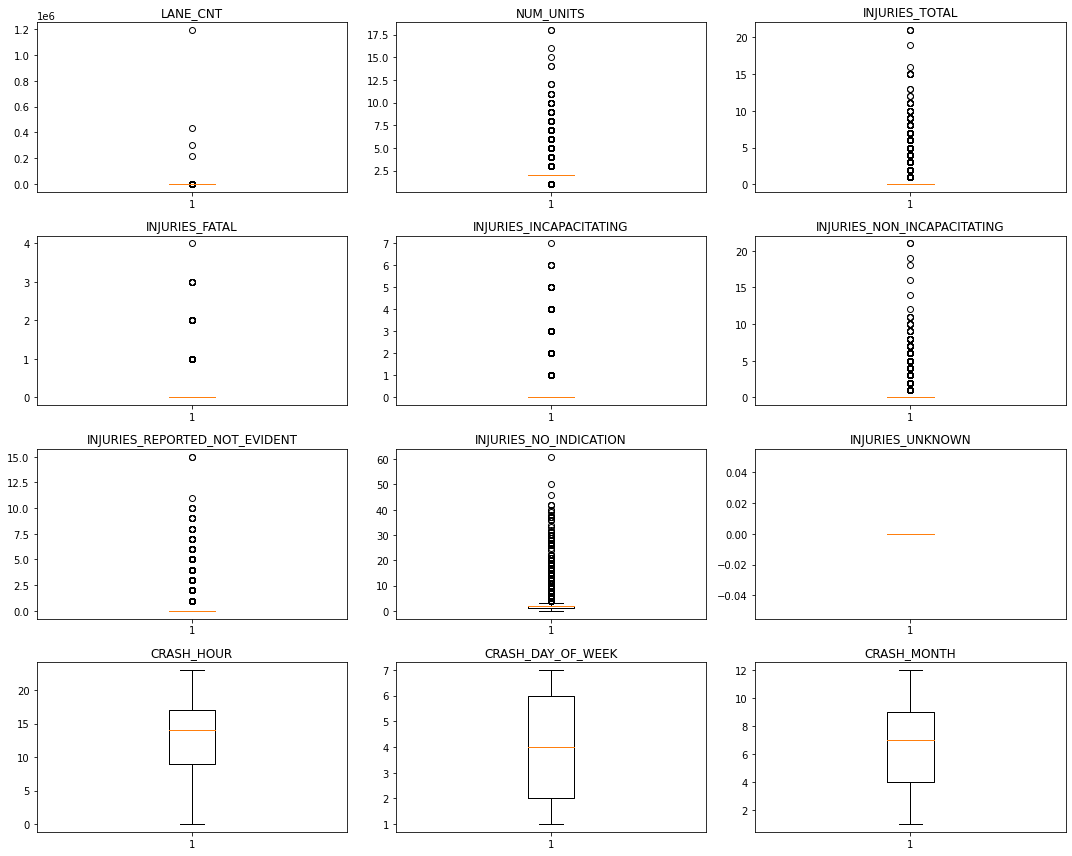

In [7]:
fig = plt.figure(figsize=(15, 12))
for index, name in enumerate(numeric_columns):
    plt.subplot(4, 3, index+1)
    plt.boxplot(filtered_source[name].dropna())
    plt.title(name)
    plt.tight_layout()
plt.show() 

In [8]:
def outlier_removal(filtered_source, column_name, lower_quantile=.00, upper_quantile=1.0, spread=3):
    """
    Remove outlier given by column name.
    
    Args:
        column_name: Column name which outlier exists.
        lower_quantile: Quantile lower bound.
        upper_quantile: Quantile upper bound.
        spread: Standard Deviation spread.
    
    Returns:
        Refined dataset.
    """
    
    # LANE_CNT as 'Total number of through lanes in eigher direction' should follow a Poisson
    # Distribution (curve shape similar like Gaussian). To remove the outlier, a easy simulation
    # is to use mean and standard deviation (SD). As extreme big value exist, so I add a further
    # restrain on 90% quantiles.
    quantile_mean = filtered_source[column_name].quantile([lower_quantile, upper_quantile]).mean()
    quantile_std = filtered_source[column_name].quantile([lower_quantile, upper_quantile]).std()
    
    # mu + 2 * sigma which covers 95% under standard Gaussion Distribution. I twist here.
    quantile_std_upper = quantile_mean + spread * quantile_std
    
    # print(quantile_mean)
    # print(quantile_std)
    # print(quantile_std_upper)
    
    # refine scope
    filtered_source = filtered_source[filtered_source[column_name] <= quantile_std_upper]
    
    return filtered_source

filtered_source = outlier_removal(filtered_source, 'LANE_CNT', lower_quantile=.00, upper_quantile=0.9, spread=5)
# filtered_source

# comment: under 5 spreads, mean, std and mean+spread*std are:
# 2.0
# 2.8284271247461903
# 16.14213562373095

#### Outlier overview

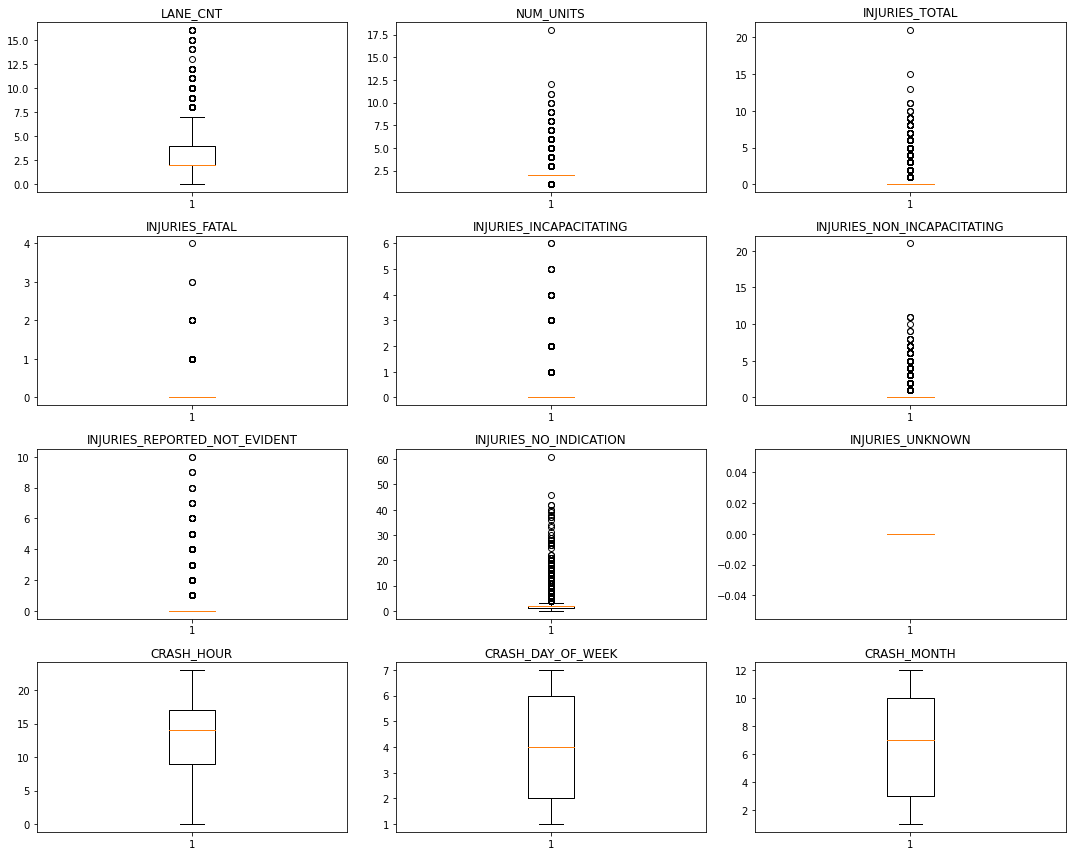

In [9]:
fig = plt.figure(figsize=(15, 12))
for index, name in enumerate(numeric_columns):
    plt.subplot(4, 3, index+1)
    plt.boxplot(filtered_source[name].dropna())
    plt.title(name)
    plt.tight_layout()
plt.show() 

<h4>Note</h4>
<ul>
<li>The only headache column is 'LANE_CNT', as highway with 4 lanes each direction is totally 14 lines (2 outter double line, 2 lines between 3 lanes, 2 inner double line, 1 spared repaire lane for 1 line) * 2 (directions), car crash should be beyond curbs at very outside to beyond curbs at the other very outside, it's already near impossible, but let's add 2 more lines, up to 16 as extreme.</li>
<li>The other boxplots with exceptions all seem reasonable, think about a case where a bus with 60 seats on a road.</li>
    <li>'INJURIES_UNKOWN' column will be discard at next step.</li>
</ul>

## Data Imputation

In [10]:
# display missing value column
print('fullness ratio | column name | set values\n')
for index, name in enumerate(filtered_source.columns):
    fullness_ratio = round(len(filtered_source[name].dropna()) / len(filtered_source), 4)
    if fullness_ratio != 1:
        print(fullness_ratio, name, set(filtered_source[name].dropna()))

fullness ratio | column name | set values

0.9796 REPORT_TYPE {'NOT ON SCENE (DESK REPORT)', 'ON SCENE', 'AMENDED'}
0.2354 INTERSECTION_RELATED_I {'N', 'Y'}
0.038 NOT_RIGHT_OF_WAY_I {'N', 'Y'}
0.2786 HIT_AND_RUN_I {'N', 'Y'}
0.0214 STATEMENTS_TAKEN_I {'N', 'Y'}
0.0037 DOORING_I {'N', 'Y'}
0.0084 WORK_ZONE_I {'N', 'Y'}
0.0068 WORK_ZONE_TYPE {'UNKNOWN', 'MAINTENANCE', 'CONSTRUCTION', 'UTILITY'}
0.0018 WORKERS_PRESENT_I {'N', 'Y'}
0.9982 MOST_SEVERE_INJURY {'FATAL', 'REPORTED, NOT EVIDENT', 'INCAPACITATING INJURY', 'NONINCAPACITATING INJURY', 'NO INDICATION OF INJURY'}
0.9982 INJURIES_TOTAL {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 13.0, 15.0, 21.0}
0.9982 INJURIES_FATAL {0.0, 1.0, 2.0, 3.0, 4.0}
0.9982 INJURIES_INCAPACITATING {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0}
0.9982 INJURIES_NON_INCAPACITATING {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 21.0}
0.9982 INJURIES_REPORTED_NOT_EVIDENT {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}
0.9982 INJU

<h4>Assumptions:</h4>
<ol>
    <li>If missing value rows is tiny compared to the pool, we can give up this part of samples.</li>
    <li>If a record has problem in one field, the other fields may also have problem.</li>
    <li>If one field is not record, it is highly possible that this filed has 0 observer or not important. Fill 0 may be better than mean or median from a common sense.</li>
    <li>If too many values missing in a column, this column seems unconvinable, and better to be discarded.</li>
    <li>Our target is 'HIT_AND_RUN_I', the missing value is highly probably as 'N', which is not running away, but we  introduced sampling bias into the system unfortunately, therefore in theory, our model maybe not so acute 'accurate' in reality.</li>
</ol>

In [11]:
def discard_data(filtered_source, fullness_threshold=0.8, blacklist=['INJURIES_UNKNOWN'],
                    negative_list=['HIT_AND_RUN_I']):
    """
    Discard data based on the observation.
    
    Args:
        filtered_source: Dataset.
        fullness_threshold: Threshold value for discard data.
        blacklist: list for discard column.
        negative_list: list for filling in 'N'.
    
    Returns:
        Refined dataset.
    """
    
    # filter 'N' in negative column list
    filtered_source[negative_list] = filtered_source[negative_list].fillna('N')

    # drop blacklist columns
    filtered_source.drop(columns=blacklist, inplace=True)

    # get discard column list
    discard_list = []
    for index, name in enumerate(filtered_source.columns):
        fullness_ratio = len(filtered_source[name].dropna()) / len(filtered_source)
        if fullness_ratio < fullness_threshold:
            discard_list.append(name)

    # drop discard columns
    filtered_source.drop(columns=discard_list, inplace=True)
    
    return filtered_source

filtered_source = discard_data(filtered_source)

In [12]:
def imputate_date(filtered_source):
    """
    Imputate data based on the observation. That is: discard categorical columns; 
        fill 0 to numeric columns, and drop duplicated records.
    
    Args:
        filtered_source: Dataset.
    
    Returns:
        Refined dataset.
    """
    
    # select object date type columns
    category_selector = make_column_selector(dtype_include=object)
    category_columns = category_selector(filtered_source)

    # select numeric date type columns
    numeric_selector = make_column_selector(dtype_include=np.number)
    numeric_columns = numeric_selector(filtered_source)

    # get missing value list
    missing_value_list = []
    for index, name in enumerate(filtered_source.columns):
        fullness_ratio = len(filtered_source[name].dropna()) / len(filtered_source)
        if fullness_ratio != 1:
            missing_value_list.append(name)
            # print(name, fullness_ratio)

    # find categorical imputation columns (in our case, all here)
    category_missing_list = list(set(category_columns).intersection(set(missing_value_list)))
    # print('Category missing columns:', category_missing_list)

    # find categorical discard columns
    numeric_missing_list = list(set(numeric_columns).intersection(set(missing_value_list)))
    # print('Numeric missing columns:', numeric_missing_list)

    # like REPORT_TYPE, MOST_SEVERE_INJURY category columns are missing tiny sample, we can discard these samples
    filtered_source.drop(columns=category_missing_list, inplace=True)

    # fill 0 to numeric columns
    imp = SimpleImputer(fill_value=0)
    filtered_source[numeric_missing_list] = imp.fit_transform(filtered_source[numeric_missing_list])
    
    # drop duplicated values
    filtered_source.drop_duplicates(inplace=True)
    
    return filtered_source

filtered_source = imputate_date(filtered_source)

#### After discard and imputation, there should be no missing value

In [13]:
filtered_source.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185484 entries, 226 to 652607
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   DEVICE_CONDITION               185484 non-null  object 
 1   WEATHER_CONDITION              185484 non-null  object 
 2   LIGHTING_CONDITION             185484 non-null  object 
 3   FIRST_CRASH_TYPE               185484 non-null  object 
 4   TRAFFICWAY_TYPE                185484 non-null  object 
 5   LANE_CNT                       185484 non-null  float64
 6   ALIGNMENT                      185484 non-null  object 
 7   ROADWAY_SURFACE_COND           185484 non-null  object 
 8   ROAD_DEFECT                    185484 non-null  object 
 9   CRASH_TYPE                     185484 non-null  object 
 10  HIT_AND_RUN_I                  185484 non-null  object 
 11  NUM_UNITS                      185484 non-null  float64
 12  INJURIES_TOTAL              

## Check Dependent Variable Skewness (Balancing)

Counter({'N': 135550, 'Y': 49934})


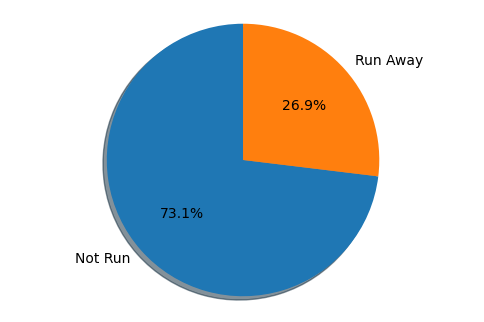

In [14]:
result = Counter(filtered_source['HIT_AND_RUN_I'])
print(result)

labels = ['Not Run', 'Run Away']
sizes = [result['N'], result['Y']]

fig1, ax1 = plt.subplots(dpi=100)
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

<p>Note:</p>
<p>For 'HIT_AND_RUN_I' dependent variable (y), the distribution is not balanced, it is a strong signal we need to <strong>use some techniques like smote to balance the data</strong>.</p>

## Numeric Data Correlation Analysis

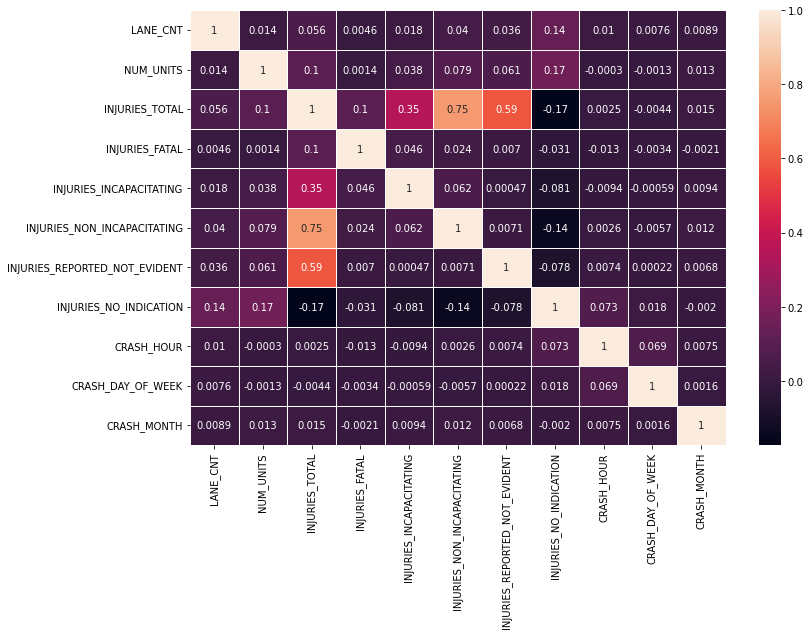

In [15]:
# select numeric date type columns
numeric_selector = make_column_selector(dtype_include=np.number)
numeric_columns = numeric_selector(filtered_source)

corr = filtered_source[numeric_columns].corr()

import seaborn as sns
import matplotlib.pylab as plt

plt.figure(figsize=(12, 8))
ax = sns.heatmap(corr, annot=True, linewidth=0.5)
plt.show()

<strong>Note</strong>
<p>This step is to check whether there is a correlation between any 2 columns, in practise, there are a lot of scenarios, especially in database, one column is saved based on the calculation from anohter column, which shows strong positive correlation (in my past experience, it will be usually more than 0.9 on Pearson's r, given null value existed in column), or strong negative correlation if 2 columns sum up equals to a fix number. If you want to check the covariance among several columns versus one columns, like calculated score or index, dimensionality reduciton methods like PCA, t-SNE, MDS (MultiDimensional Scaling) etc. will usually give a good answer.</p>
<p>In this case, it looks fine, and the correlation between any 2 columns are acceptable.</p>

## Encoding Analysis

### Unique values in each columns

In [16]:
for column in filtered_source.columns:
    print(column, set(filtered_source[column]))

DEVICE_CONDITION {'FUNCTIONING IMPROPERLY', 'UNKNOWN', 'FUNCTIONING PROPERLY', 'MISSING', 'NOT FUNCTIONING', 'NO CONTROLS', 'OTHER', 'WORN REFLECTIVE MATERIAL'}
WEATHER_CONDITION {'FREEZING RAIN/DRIZZLE', 'UNKNOWN', 'CLEAR', 'SNOW', 'SEVERE CROSS WIND GATE', 'OTHER', 'FOG/SMOKE/HAZE', 'RAIN', 'CLOUDY/OVERCAST', 'SLEET/HAIL'}
LIGHTING_CONDITION {'DAYLIGHT', 'UNKNOWN', 'DAWN', 'DUSK', 'DARKNESS, LIGHTED ROAD', 'DARKNESS'}
FIRST_CRASH_TYPE {'ANIMAL', 'PARKED MOTOR VEHICLE', 'ANGLE', 'TURNING', 'PEDESTRIAN', 'OTHER OBJECT', 'REAR TO SIDE', 'REAR TO FRONT', 'SIDESWIPE OPPOSITE DIRECTION', 'HEAD ON', 'OVERTURNED', 'SIDESWIPE SAME DIRECTION', 'OTHER NONCOLLISION', 'TRAIN', 'PEDALCYCLIST', 'REAR END', 'FIXED OBJECT'}
TRAFFICWAY_TYPE {'DIVIDED - W/MEDIAN BARRIER', 'UNKNOWN', 'DIVIDED - W/MEDIAN (NOT RAISED)', 'DRIVEWAY', 'UNKNOWN INTERSECTION TYPE', 'FOUR WAY', 'NOT DIVIDED', 'RAMP', 'ALLEY', 'OTHER', 'CENTER TURN LANE', 'ONE-WAY', 'T-INTERSECTION', 'PARKING LOT'}
LANE_CNT {0.0, 1.0, 2.0, 3.0, 

In [17]:
def encode_data(filtered_source, dependent_column_name = 'HIT_AND_RUN_I'):
    """
    Apply one-hot encoding to category variable, then combined continues variables
    
    Args:
        filtered_source: Dataset.
        dependent_column_name: The dependent variable name
    
    Returns:
        enc_source: encoded dataset
        y: binary dependent variable
    """

    # separate independent variables and dependent variable
    dependent_column = filtered_source[dependent_column_name]
    y = [1 if element == 'Y' else 0 for element in dependent_column]

    # select object date type columns
    category_selector = make_column_selector(dtype_include=object)
    category_columns = category_selector(filtered_source)
    category_columns.remove(dependent_column_name)

    # select numeric date type columns
    numeric_selector = make_column_selector(dtype_include=np.number)
    numeric_columns = numeric_selector(filtered_source)
    filtered_source_num = filtered_source[numeric_columns]
    filtered_source_num.reset_index(inplace=True)

    # apply one-hot encoding
    enc = OneHotEncoder()
    enc_source_category_temp = enc.fit_transform(filtered_source[category_columns])
    # one-hot encoding on category variables
    enc_source_category = pd.DataFrame(enc_source_category_temp.toarray(), columns=enc.get_feature_names_out())
    # concatenate category variable with continuous variables
    source_enc = pd.concat([filtered_source_num, enc_source_category.reindex(filtered_source_num.index)], 
                           axis=1, ignore_index=True)
    source_enc.columns = list(filtered_source_num.columns) + list(enc_source_category.columns)
    
    # drop index
    source_enc.drop(columns='index', inplace=True)

    return source_enc, y

source_enc, y = encode_data(filtered_source)
print(source_enc.shape)

(185484, 88)


<strong>Note:</strong>
<p>Though in numeric columns, all value should be integer type, some float precision values do exist, it may be some reasons to leave it as float, the amount is tiny, leaving those records untouch won't make huge influence.</p>
<p>Seperate independent variables and dependent variable is also in encode_data function. If in a scrutinized engineering censorship perspective, this part should be in two functions.</p>

## Dependent Variable Explained Variance Analysis

<p>The analysis here is to give a glimpse on how all columns have an impact on prediction based on variance, with PCA explained_variance_ratio (sum up equal to 1). Roughly speaking, a more diverse column has more 'sayings' than a non-diverse column.</p>

component number: 88
PCA sum of explained variance ratio 0.9999999999999998


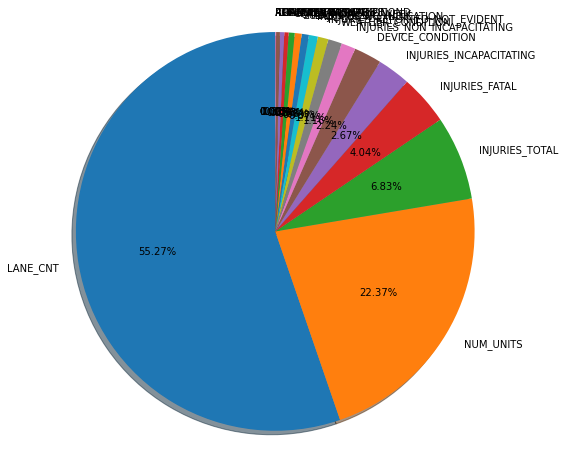

{'LANE_CNT': 0.5546683809085132,
 'NUM_UNITS': 0.2245327373841992,
 'INJURIES_TOTAL': 0.06850429306929304,
 'INJURIES_FATAL': 0.04058407587209873,
 'INJURIES_INCAPACITATING': 0.026810999651237937,
 'DEVICE_CONDITION': 0.022491056649888753,
 'INJURIES_NON_INCAPACITATING': 0.011606024946168346,
 'WEATHER_CONDITION': 0.011177823125676382,
 'INJURIES_REPORTED_NOT_EVIDENT': 0.008690885526295622,
 'INJURIES_NO_INDICATION': 0.007294134683201365,
 'CRASH_HOUR': 0.005820168129826687,
 'CRASH_DAY_OF_WEEK': 0.005630697647923863,
 'CRASH_MONTH': 0.00488825403128095,
 'FIRST_CRASH_TYPE': 0.003518743250384472,
 'CRASH_TYPE': 0.003518743250384472,
 'LIGHTING_CONDITION': 0.0031090083554033364,
 'TRAFFICWAY_TYPE': 0.0006293845352672936,
 'ALIGNMENT': 4.109244468078256e-05,
 'ROADWAY_SURFACE_COND': 2.2397886599757296e-06,
 'ROAD_DEFECT': 5.335044930642654e-30}

In [18]:
from sklearn.decomposition import PCA

# use all components
pca = PCA()
source_pca = pca.fit_transform(source_enc)

print('component number:', len(pca.explained_variance_ratio_))
print('PCA sum of explained variance ratio', sum(pca.explained_variance_ratio_))


# setup a temp result dictionary, and sum up explain variance ratio reflected back to original dataset columns.
temp = dict()
for index, column in enumerate(source_enc.columns):
    for original_column_name in filtered_source.columns:
        if original_column_name in column:
            if original_column_name not in temp.keys():
                temp[original_column_name] = pca.explained_variance_ratio_[index]
            else:
                temp[original_column_name] += pca.explained_variance_ratio_[index]

# decreasing value by order
temp = dict(sorted(temp.items(), key=lambda item: item[1], reverse=True))

# make pie chart plot to illustrate result
labels = temp.keys()
values = temp.values()
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(values, labels=labels, autopct='%1.2f%%', shadow=True, startangle=90)
# equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')
plt.show()
temp

# Feature Engineering

## PCA

#### The parts below in feature enineering can be chained inside the pipeline, so no function is written under this section.

PCA 95% varianced reserved, length: 10
PCA top explained variance ratio: [0.55466838 0.22453274 0.06850429 0.04058408 0.026811   0.01160602
 0.00869089 0.00729413 0.00582017 0.0056307 ]
PCA top explained variance ratio sum: 0.9541423978187581


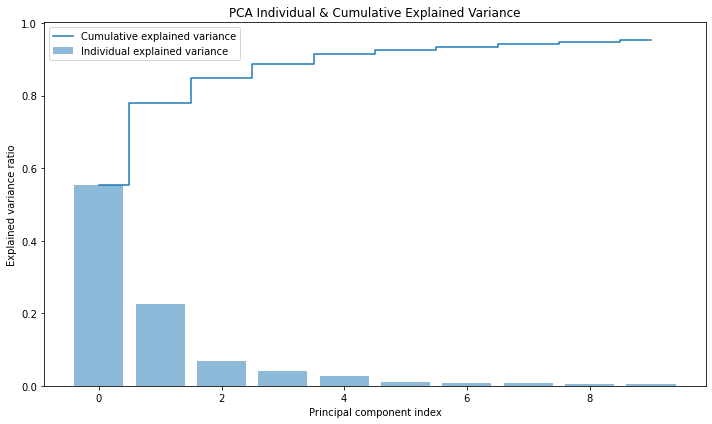

In [19]:
pca_component_percent_threshold = 0.95

# PCA with n_components percentage
pca = PCA(n_components=pca_component_percent_threshold)
source_pca = pca.fit_transform(source_enc)
explain_variance_ratio = pca.explained_variance_ratio_
print('PCA %d%% varianced reserved, length: %d' % (pca_component_percent_threshold*100, len(explain_variance_ratio)))
print('PCA top explained variance ratio:', explain_variance_ratio)
print('PCA top explained variance ratio sum:', sum(explain_variance_ratio))

# cumulative sum of eigenvalues, this will be used to create step plot
# that is, visualization for variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(explain_variance_ratio)

# step plot
plt.figure(figsize=(10, 6))
plt.bar(range(0, len(explain_variance_ratio)), explain_variance_ratio, alpha=0.5,
        align='center', label='Individual explained variance')
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',
        label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('PCA Individual & Cumulative Explained Variance')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

<h3>Note: how PCA works</h3>
<ol>
	<li>Substract the mean of each variables.</li>
	<li>Calculate the covariance matrix.</li>
	<li>Compute Eigenvalues and Eigenvectors.</li>
	<li>Sort Eigenvalues in descending order.</li>
	<li>Select a subset from the arranged Eigenvalues matrix.</li>
	<li>Transform the data back.</li>
</ol>

## Standardization

In [20]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
source_std = std_scaler.fit_transform(source_pca)

## Data Balancing & Basedline Metrics

In [21]:
from imblearn.combine import SMOTEENN


sme = SMOTEENN(sampling_strategy='all', n_jobs=-1)
X_res, y_res = sme.fit_resample(source_std, y)
sme_counter = Counter(y_res)


print('Dataset shape before SMOTE:', Counter(y))
print('Dataset shape after  SMOTE:', sme_counter)

# Measure baseline
baseline = sme_counter[1] / (sme_counter[0] + sme_counter[1])
print('Baseline accuracy:', '\033[91m', baseline, '\033[0m')

Dataset shape before SMOTE: Counter({0: 135550, 1: 49934})
Dataset shape after  SMOTE: Counter({1: 81352, 0: 55669})
Baseline accuracy:  0.593719210923873 


<h3>Note: how smote-enn works</h3>
<ul>
	<li>(Start of SMOTE) Choose random data from the minority class.</li>
		<ol>
			<li>Calculate the distance between the random data and its k nearest neighbors.</li>
			<li>Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.</li>
			<li>Repeat step number 2–3 until the desired proportion of minority class is met. (End of SMOTE)</li>
		</ol>
    <br/>
	<li>(Start of ENN) Determine K, as the number of nearest neighbors. If not determined, then K=3.</li>
		<ol>
			<li>Find the K-nearest neighbor of the observation among the other observations in the dataset, then return the majority class from the K-nearest neighbor.</li>
			<li>If the class of the observation and the majority class from the observation’s K-nearest neighbor is different, then the observation and its K-nearest neighbor are deleted from the dataset.</li>
			<li>Repeat step 2 and 3 until the desired proportion of each class is fulfilled. (End of ENN)</li>
		</ol>
</ul>

## Train Test Split

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res)
print('Train dataset shape:', X_train.shape)
print('Test  dataset shape:', X_test.shape)

Train dataset shape: (102765, 10)
Test  dataset shape: (34256, 10)


# Modeling

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
    precision_score, recall_score, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV

def model_evaluation(model, X_test, y_test):
    """
    Custom evaluation function which provide confusion matrix and its derivatives
    
    Args:
        model: the model which make predict.
        X_test: test set independent variables.
        y_test: test set dependent variables.
    
    Returns:
        precision: TP/(TP+FP)
        recall: TP/(TP+FN)
        accuracy: (TP+TN)/ALL
    """
    
    # get predict value
    y_pred = model.predict(X_test)
    
    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()
    
    # show each quadrant, and derivative metrics
    tn, fp, fn, tp = cm.ravel()
    print('TP:', tp)
    print('FP:', fp)
    print('FN:', fn)
    print('TN:', tn)
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    print('precision [TP/(TP+FP)]:', round(precision, 4))
    print('recall [TP/(TP+FN)]:', round(recall, 4))
    print('accuracy [(TP+TN)/ALL]:', round(accuracy, 4))
    return precision, recall, accuracy

## Logistic Regression

{'solver': 'newton-cg'}


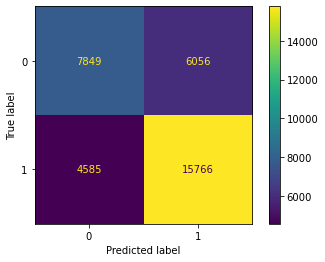

TP: 15766
FP: 6056
FN: 4585
TN: 7849
precision [TP/(TP+FP)]: 0.7225
recall [TP/(TP+FN)]: 0.7747
accuracy [(TP+TN)/ALL]: 0.6894


In [24]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter = 1000)


lr_parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}


# grid search with cross validation
lr_gdcv = GridSearchCV(lr_clf, lr_parameters, scoring='accuracy', cv=3, n_jobs=-1)
lr_gdcv.fit(X_train, y_train)
print(lr_gdcv.best_params_)

# make prediction
lr_precision, lr_recall, lr_accuracy = model_evaluation(lr_gdcv, X_test, y_test)

## Decision Tree

{'criterion': 'gini', 'max_depth': 9}


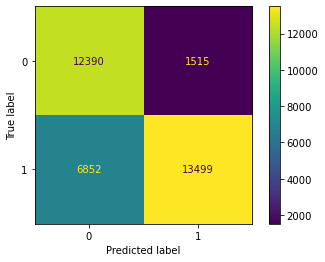

TP: 13499
FP: 1515
FN: 6852
TN: 12390
precision [TP/(TP+FP)]: 0.8991
recall [TP/(TP+FN)]: 0.6633
accuracy [(TP+TN)/ALL]: 0.7558


In [25]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()


dt_parameters = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': range(2, X_train.shape[1])
}
dt_gdcv = GridSearchCV(dt_clf, dt_parameters, scoring='accuracy',  cv=3, n_jobs=-1)
dt_gdcv.fit(X_train, y_train)
print(dt_gdcv.best_params_)

# make prediction
dt_precision, dt_recall, dt_accuracy = model_evaluation(dt_gdcv, X_test, y_test)

## Random Forest

{'max_depth': 9, 'max_features': 'log2'}


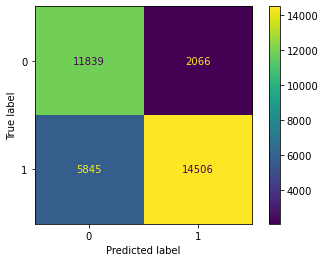

TP: 14506
FP: 2066
FN: 5845
TN: 11839
precision [TP/(TP+FP)]: 0.8753
recall [TP/(TP+FN)]: 0.7128
accuracy [(TP+TN)/ALL]: 0.7691


In [26]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=300, n_jobs=-1)

rf_parameters = {
    'max_depth': range(5, X_train.shape[1]),
    'max_features': ['sqrt', 'log2']
}
rf_gdcv = GridSearchCV(rf_clf, rf_parameters, scoring='accuracy',  cv=3, n_jobs=-1)
rf_gdcv.fit(X_train, y_train)
print(rf_gdcv.best_params_)

# make prediction
rf_precision, rf_recall, rf_accuracy = model_evaluation(rf_gdcv, X_test, y_test)

## XGBoost

{'booster': 'gbtree'}


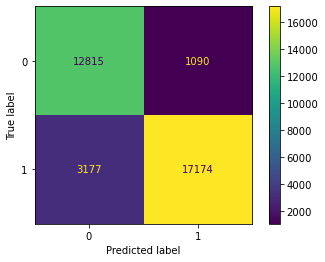

TP: 17174
FP: 1090
FN: 3177
TN: 12815
precision [TP/(TP+FP)]: 0.9403
recall [TP/(TP+FN)]: 0.8439
accuracy [(TP+TN)/ALL]: 0.8754


In [27]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(n_jobs=-1, use_label_encoder=False, eval_metric='auc')

xgb_parameters = {'booster': ['gbtree', 'gblinear', 'dart']}

xgb_gdcv = GridSearchCV(xgb_clf, xgb_parameters, scoring='accuracy', cv=3, n_jobs=-1)
xgb_gdcv.fit(X_train, y_train)
print(xgb_gdcv.best_params_)

# make prediction
xgb_precision, xgb_recall, xgb_accuracy = model_evaluation(xgb_gdcv, X_test, y_test)

## Stacking

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, StackingClassifier


gbdt_clf = HistGradientBoostingClassifier(scoring='accuracy')

# Stacking
estimators = [
    ('logistic_regression', lr_clf),
    ('decision_tree', dt_clf),
    ('random_forest', rf_clf)
]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=gbdt_clf)
pipe = Pipeline(steps=[('stacking', stacking_clf)])
pipe

Pipeline(steps=[('stacking',
                 StackingClassifier(estimators=[('logistic_regression',
                                                 LogisticRegression(max_iter=1000)),
                                                ('decision_tree',
                                                 DecisionTreeClassifier()),
                                                ('random_forest',
                                                 RandomForestClassifier(n_estimators=300,
                                                                        n_jobs=-1))],
                                    final_estimator=HistGradientBoostingClassifier(scoring='accuracy')))])

{'stacking__decision_tree__criterion': 'gini'}


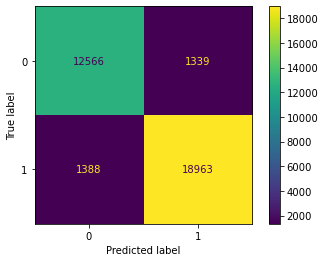

TP: 18963
FP: 1339
FN: 1388
TN: 12566
precision [TP/(TP+FP)]: 0.934
recall [TP/(TP+FN)]: 0.9318
accuracy [(TP+TN)/ALL]: 0.9204


In [29]:
stacking_parameters = {
    # Note: Stacking is time consuming, there can be more tune parameters if time permitted (uncomment below).
    # 'stacking__logistic_regression__solver': ['newton-cg', 'liblinear','saga'],
    'stacking__decision_tree__criterion':['gini', 'log_loss'],
    # 'stacking__random_forest__max_features': ['sqrt', 'log2']
}

stacking_gdcv = GridSearchCV(pipe, stacking_parameters, scoring='accuracy', cv=3, n_jobs=-1)
stacking_gdcv.fit(X_train, y_train)
print(stacking_gdcv.best_params_)

# make prediction
stacking_precision, stacking_recall, stacking_accuracy = model_evaluation(stacking_gdcv, X_test, y_test)

# Evaluation & Explainability

## Model Evaluation

### Model Comparision (AUC-ROC)

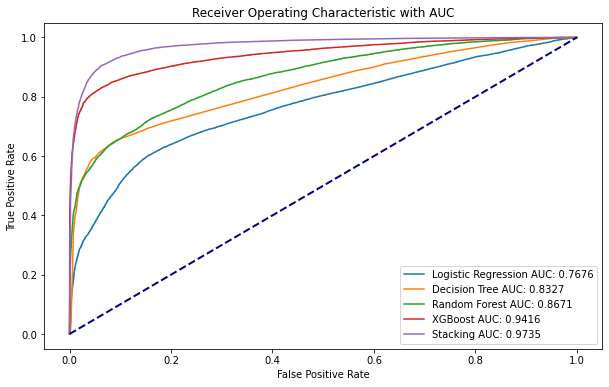

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

def calculate_auc(model, X_test, y_test):
    
    # calculate predict probability
    y_pred_proba = model.predict_proba(X_test)[::,1]
    
    # get TPR, FPR
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    
    # calculate auc
    auc = roc_auc_score(y_test, y_pred_proba)
    
    return fpr, tpr, auc


# Plot AUC-ROC Curve
plt.figure(figsize=(10, 6))

# logistic regression
lr_fpr, lr_tpr, lr_auc = calculate_auc(lr_gdcv, X_test, y_test)
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression AUC: ' + str(round(lr_auc, 4)))

# Decision Tree
dt_fpr, dt_tpr, dt_auc = calculate_auc(dt_gdcv, X_test, y_test)
plt.plot(dt_fpr, dt_tpr, label='Decision Tree AUC: ' + str(round(dt_auc, 4)))

# Random Forest
rf_fpr, rf_tpr, rf_auc = calculate_auc(rf_gdcv, X_test, y_test)
plt.plot(rf_fpr, rf_tpr, label='Random Forest AUC: ' + str(round(rf_auc, 4)))

# XGBoost
xgb_fpr, xgb_tpr, xgb_auc = calculate_auc(xgb_gdcv, X_test, y_test)
plt.plot(xgb_fpr, xgb_tpr, label='XGBoost AUC: ' + str(round(xgb_auc, 4)))

# Stacking
stacking_fpr, stacking_tpr, stacking_auc = calculate_auc(stacking_gdcv, X_test, y_test)
plt.plot(stacking_fpr, stacking_tpr, label='Stacking AUC: ' + str(round(stacking_auc, 4)))

# Random line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic with AUC')
plt.legend(loc='lower right')
plt.show()

### Model Performance Overview

In [31]:
columns = ['precision', 'recall', 'accuracy', 'AUC']
index = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'Stacking']
data = [[lr_precision, lr_recall, lr_accuracy, lr_auc],
        [dt_precision, dt_recall, dt_accuracy, dt_auc],
        [rf_precision, rf_recall, rf_accuracy, rf_auc],
        [xgb_precision, xgb_recall, xgb_accuracy, xgb_auc],
        [stacking_precision, stacking_recall, stacking_accuracy, stacking_auc]]
pd.DataFrame(data, columns=columns, index=index)

,precision,recall,accuracy,AUC
Logistic Regression,0.722482,0.774704,0.689368,0.767603
Decision Tree,0.899094,0.663309,0.755751,0.832720
Random Forest,0.875332,0.712791,0.769062,0.867091
XGBoost,0.940320,0.843890,0.875438,0.941564
Stacking,0.934046,0.931797,0.920394,0.973517


## Model Explainability

### Shapley Summary

In [32]:
import shap

explainer = shap.Explainer(stacking_gdcv.predict, X_train[::100])

# calculates the SHAP values - TIME COMSUMING
shap_values = explainer(X_train[::100])

Exact explainer: 1029it [11:46,  1.44it/s]                                      


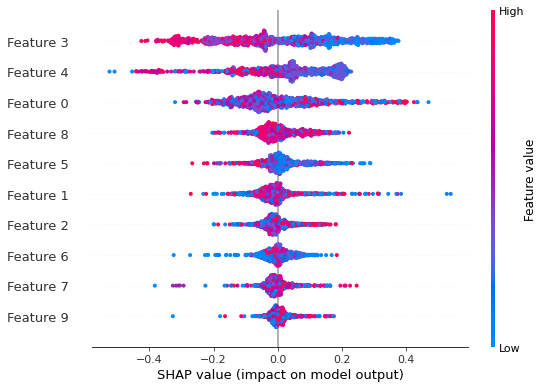

In [33]:
# shap.initjs()
shap.summary_plot(shap_values)

<h4>Comment</h4>
<p>SHAP shows the contribution or the importance of teach feature on the prediction of the model, it does not evaluate the quality of the prediction itself.</p>
<p>Shap summary is from higher level perspectives to explain how each features influence the model prediction.</p>
<h4>How to read the summary</h4>
<ul>
	<li>Features from top to bottom is feature importance</li>
	<li>All dots on the plot represent a single observation.</li>
</ul>

<p>E.g. Feature 3 is the most dominated feature among all, which lower value (color blue) has positive (SHAP value toward +1, bottom axis) impact on the prediction; and higher value (color red) has negative impact</p>

### Individual Case Explaination

In [34]:
import random
from lime import lime_tabular 

explainer = lime_tabular.LimeTabularExplainer(
    X_train,
    mode='classification',
    feature_names=['Feature_' + str(number) for number in range(X_test.shape[1])]
)

# random select a case from test to predict and explain
index = random.randint(1, len(X_test))
print('Test case index:', index)
print('Prediction:', stacking_gdcv.predict(X_test[index].reshape(1, -1)))
print('Ground truth:', y_test[index])

explanation = explainer.explain_instance(X_test[index], stacking_gdcv.predict_proba, num_features=X_test.shape[1])
explanation.show_in_notebook()

Test case index: 16216
Prediction: [1]
Ground truth: 1


<h4>Note</h4>
<p>LIME instance plot is from a lower perspectives to explain how the model make prediction for a single observertion based on current features.</p>
<h4>How to read LIME instance explaination</h4>
<p>From left to right</p>
<ul>
	<li>Left: prediction probability</li>
	<li>middle: category explaination, for example, (feature 4 > 0.28) has a negative influence on predicted category 0 (Not run away).</li>
	<li>right: feature name with value (local weight from the model itself).</li>
</ul>

<h2>Answers for the very beginning background questions</h2>
<strong>I am curious what factors are most related to hit and run? And can we predict the driver behavior after the crash? For what percentage of accuracy? Could a case study be explained as an example?</strong>

<strong>Q1: I am curious what factors are most related to hit and run?</strong>
<p><strong>Re:</strong> From EDA - Dependent Variable Explained Variance Analysis, 'LANE_CNT', 'NUM_UNITS' and 'INJURIES_TOTAL' are top 3 most influential factors related to hit and run behaviour, whose sum of explained variance ratio is as high as 55.27% + 22.37% + 6.83% = 84.47%.</p>

<strong>Q2: And can we predict the driver behavior after the crash?</strong>
<p><strong>Re:</strong> From Modeling part, yes, several models can fit the job, and the best model is a custom stacking model.</p>

<strong>Q3: For what percentage of accuracy?</strong>
<p><strong>Re:</strong> From Evaluation & Explainability - Model Performance Overview, the best accuracy is 92.04%.</p>

<strong>Q4: Could a case study be explained as an example?</strong>
<p><strong>Re:</strong> From Evaluation & Explainability - Individual Case Study Explaination, a study case from test set, prediction and ground truth are both positive, which means driver did hit and run away. As the original features are so many, on both numeric and categorical ones, we use PCA (decompositing Eigenmatrix) method to project the features onto 10 components, which reserves 95% amount of variance (meaningness). Each calculated feature has a domain to influence the result to positive (run away), or negative (not run away). For example, (feature 4 > 0.28) has a negative influence towards predicted category 0 with value 2.72. Sum all those components calculated values will eventually decide the prediction true or false.</p>